# Challenge 3: PySpark Demo

In this Challenge we'll show you how to use Spark to run intensive computation jobs in Jupyter Notebook. 

#### Suggested time on this challenge: 120-150 min

So far you should have installed PySpark in local mode, configured your environment variables, and started Jupyter Notebook with PySpark. If you haven't completed any of the previous steps, please go back and complete them because otherwise you won't be able to complete this challenge.

If everything works so far, you should be able to create a `SparkContext` instance in Jupyter Notebook. Try to execute the next cell where the code is already written for you to create a new `SparkContext` instance.

In [1]:
# Create a `SparkContext` instance or reuse an existing one
sc = SparkContext.getOrCreate()

[Spark localhost link](http://localhost:4040/jobs/)

No errors? Congrats! But in case you do, review Challenge 2 and google your error to see what could have possibly gone wrong.

SparkContext is a library that helps you access the Spark execution environment in order to use the [Spark Python APIs](https://spark.apache.org/docs/latest/api/python/index.html). We will show you an example of how to call the Spark API using the SparkContext instance.

But before we start the real work, we'd like you to get familiar with the concept of [benchmarking](https://en.wikipedia.org/wiki/Benchmark_(computing)). Benchmarking is a common technique in software engineering and data engineering to evaluate the efficiency of your codes. The idea is to measure the execution time of your program and research if there is room to improve your code in order to get the job done with shorter time. In machine learning a lot of times you'be doing repeated sampling and complex queries that could run for hours, days, or even weeks. It is important that you improve your code efficiency whenever you can. Otherwise you'll waste a lot of time and computation powers in executing inefficient code.

We will benchmark a code snippet that estimates Pi (`π`) by repeated sampling. We will first benchmark this without using Spark. The idea of the Pi estimation is to randomly generate many points with `x` and `y` coordinates between 0 and 1. These points will fall in a square whose side length is 1 (the upper right grid of the square in the image below that combines the red and green areas). We will count the number of sample points that fall into the 1/4 circle sector (the area in red) against all points which allows us to calculate Pi.

![pi.png](pi.png)

Below are the math formulas to calculate the probability of a point to fall into the 1/4 circle sector (*A0*) and the square area (*A0*).

```
A0 = π * r^2
A1 = (2r)^2
```

From the formulas above, you can deduce ` π = 4 * A0` if *r* is 1, which means Pi equals to 4 times the probability of a point falling into the red area.

Because this lab focuses on Spark, we will provide you the code snippet for estimating Pi based on the mathematical concept discussed above. Read the code carefully and make sure you fully understand what the code does.

In [2]:
import numpy as np
from timeit import default_timer as timer

def inside(p):
    """
    Generate a random point and check if the point is within the circle with radius=1.
    
    Returns:
        (bool) whether the generated point is within the circle area
    """
    x, y = np.random.random(), np.random.random()
    return x*x + y*y < 1

def estimate_pi(num_samples):
    """
    Estimate the value of Pi by means of repeated sampling. Benchmark the repeated sampling time cost.
    
    Params:
        num_sampes (int): the number of sample points to generate
    
    Returns:
        (float) estimated value of Pi
    """
    print("Executing Spark job...")
    start = timer()
    dots = list(filter(inside,list(range(num_samples)))) 
    count = len(dots)
    end = timer()
    print("Spark job ended. Total time elapsed: %s" % (end-start))
    return 4.0 * count / num_samples,end-start

In the cell below, call `estimate_pi()` with `50000`, `500000`, and `5000000` sample sizes. See what you get.

In [3]:
# Your code here

samples = [e*(10**k) for k in range(0,8) for e in range(1,10)]

data_ls = []
for item in samples:
    pi_z,times = estimate_pi(item)
    data_ls.append([item,pi_z,times])
    print('N of samples: ',item,' | Pi: ',pi_z,' | Time: ',times)


Executing Spark job...
Spark job ended. Total time elapsed: 0.0005363199998100754
Executing Spark job...
Spark job ended. Total time elapsed: 0.00019729799987544538
Executing Spark job...
Spark job ended. Total time elapsed: 0.00023508600042987382
Executing Spark job...
Spark job ended. Total time elapsed: 0.00012540200077637564
Executing Spark job...
Spark job ended. Total time elapsed: 0.00016692699955456192
Executing Spark job...
Spark job ended. Total time elapsed: 0.0001727010003378382
Executing Spark job...
Spark job ended. Total time elapsed: 0.0001684279995970428
Executing Spark job...
Spark job ended. Total time elapsed: 0.0003653049998320057
Executing Spark job...
Spark job ended. Total time elapsed: 0.00014667300001747208
Executing Spark job...
Spark job ended. Total time elapsed: 0.00021756599926447961
Executing Spark job...
Spark job ended. Total time elapsed: 0.0004026690003229305
Executing Spark job...
Spark job ended. Total time elapsed: 0.0005546080001295195
Executing 

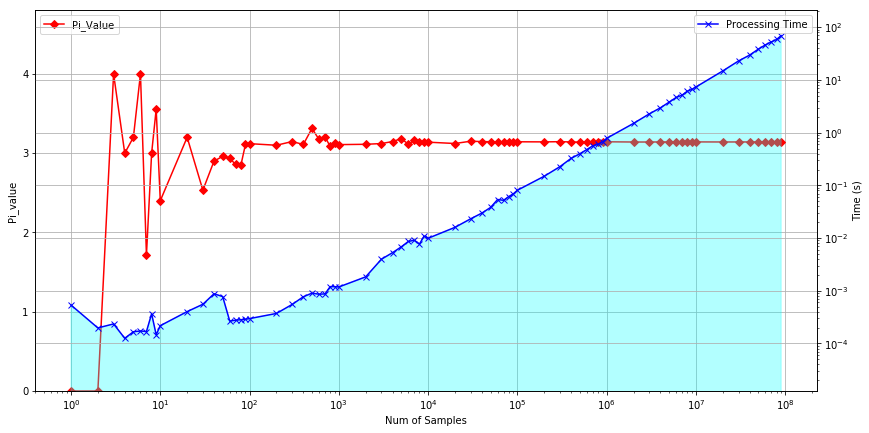

In [5]:
import matplotlib.pyplot as plt

data = np.asarray(data_ls)

fig = plt.figure(figsize=(14,7))

ax=plt.subplot(111)
ax.plot(data[:,0],data[:,1],label='Pi_Value',color='red',marker='D')
ax.set_xlabel('Num of Samples')
ax.set_ylabel('Pi_value')
ax.grid()
ax.set_ylim(min(data[:,1])*0.8,max(data[:,1])*1.2)
ax.legend(loc='upper left')
ax1=ax.twinx()
ax1.plot(data[:,0],data[:,2],color='blue',marker='x',label='Processing Time')
ax1.fill_between(data[:,0],data[:,2],color='cyan',alpha=0.3)
ax1.set_ylabel('Time (s)')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.grid()
ax1.set_ylim(min(data[:,2])*0.1,max(data[:,2])*3)
ax1.legend(loc='upper right')

plt.show()

As you see, the excution time increases when you increase the sample size. In addition, the accuracy of the Pi value increases as you increase the sample size. But if you keep increasing the sample size you have to wait a long time for the script to finish execution. What can you do if you really need to run a very large sample size?

There are several options. You can **use a computer with higher processing speed**. This allows you to execute the sampling jobs faster. But this is usually not the best option because the improvement of CPU processing speed has limited impacts on executing millions of sampling jobs.

The second option is to **run multiple sampling jobs in parallel**. In case you don't know yet, Python is a linear programming language which means it executes one job then the next. If you wait for millions of samping jobs to finish in a single queue it will take you a lot of time. Therefore, most modern programming languages including Python and R have introduced a feature called [parallel programming or parallel processing](https://wiki.python.org/moin/ParallelProcessing) so that you can save time by running several tasks at the same time. Say if your sampling jobs would take 1,000 seconds to finish in a single queue, you can finish them in 250 seconds with 4 parallel processing queues. Note that this time calculation is theoretical. In reality with 4 parallel queues the finishing time is usually more than 250 seconds because Python has to spend some overhead time to [spawn](https://en.wikipedia.org/wiki/Spawn_(computing)) the parallel processes.

**How many parallel processes you can run depends on how many CPU cores you have** on your computer. If you have 8 CPU cores on your computer, the max number of parallel processes you can run is 8. What if you attempt to run more processes than the number of your CPU cores? The excessive jobs will be queued up in the same CPU core which makes your parallel programming meaningless. Therefore, in order to run parallel programming you need to use a multi-core computer and the parallel processes can't exceed your number of CPU cores. 

Then you may ask, **should I allocate all my CPU cores to parallel programming?** Remember that besides executing the parallel programming scripts, your computer's CPUs also need to run your operation system and some other system processes. Therefore, **you typically reserve 1-2 CPU cores for the OS and system processes and allocate the rest to parallel programming**. However, with Apache Spark you don't need to manually allocate the CPU cores because Spark will automatically do that for you depending on how many cores it has access to. Remember in Challenge 2 we asked you to use the following command to start Spark:

```
$SPARK_PATH/bin/pyspark --master "local[*]"
```

The `*` directive tells Sparks to decide how many CPU cores to use by itself. If you start Spark with `local[2]`, it means you allocate 2 CPU cores to Spark.

Another note is **your computer memory may also set a bottleneck on the performance of parallel programming**. When your computer runs parallel jobs, its memory consumption is multiplied. If a single process consumes 256mb memory, four parallel processes will consume 1,024mb memory. This is in addition to the memory consumption of Apache Spark that keeps your dataset in the memory to improve processing speed. Therefore, in order to use Spark successfully in local mode, you really need a high-end computer with multi-cores and high memory (8gb or above). If your computer runs out of memory, your parallel scripts will be shut down.  

So far we have discussed the multi-core and memory concerns of running Spark in the local mode. These concerns are similar if you run Spark in the cluster mode. With the cluster mode each cluster has its own memory and one or multiple cores. Spark is smart enough to automatically allocate the resources in the cluster mode too.

Now let's move on to the real stuff. How do you run parallel programming with Apache Spark? **That is achieved by invoking Spark's `parallelize` method** ([documentation](https://spark.apache.org/docs/latest/rdd-programming-guide.html#parallelized-collections)). In the next cell, we have a function called `estimate_pi_parallel` for you to complete. You will rewrite the `estimate_pi` function we gave you earlier and use `SparkContext.parallelize` to spawn parallel processes to create the random point samples then use the samples to estimate Pi. 

If you are stuck, you can reference [this Jupyter Notebook example](https://github.com/mGalarnyk/Installations_Mac_Ubuntu_Windows/blob/master/Spark/Estimating%20PI.ipynb) (but don't simply copy and paste). **Make sure to benchmark your function so that we know if Spark helps improve the code executing time.**

*Hint: You can re-use the `inside` function we gave you earlier in your code.*

In [7]:
import time
def estimate_pi_parallel(num_samples):
    """
    Estimate the value of Pi by means of repeated sampling using Spark's `parallelize` method. 
    Benchmark the repeated sampling time cost.
    
    Params:
        num_sampes (int): the number of sample points to generate
    
    Returns:
        (float) estimated value of Pi
    """
    # Your code here
    t0=time.time()
    count = sc.parallelize(range(0, num_samples)).filter(inside).count() 
    t1=time.time()
    tt=t1-t0
    return 4 * count/num_samples,tt

Next, test your `estimate_pi_parallel` function with `5000000` and `50000000` sample sizes. Run it more than once for each sample size to see how the execution time varies.

In [8]:
# Your code here
times2 = []
pi_2 = []

for item in samples:
    pi_z,t = estimate_pi_parallel(item)
    print('Samples: ',item,' | Pi: ',pi_z,' | Time: ',t)
    times2.append(t)
    pi_2.append(pi_z)

Samples:  1  | Pi:  4.0  | Time:  0.9641759395599365
Samples:  2  | Pi:  4.0  | Time:  0.10535311698913574
Samples:  3  | Pi:  4.0  | Time:  0.10531282424926758
Samples:  4  | Pi:  4.0  | Time:  0.10679817199707031
Samples:  5  | Pi:  4.0  | Time:  0.11167216300964355
Samples:  6  | Pi:  4.0  | Time:  0.1152033805847168
Samples:  7  | Pi:  4.0  | Time:  0.11713814735412598
Samples:  8  | Pi:  4.0  | Time:  0.11654043197631836
Samples:  9  | Pi:  4.0  | Time:  0.1062321662902832
Samples:  10  | Pi:  4.0  | Time:  0.10468554496765137
Samples:  20  | Pi:  4.0  | Time:  0.10960054397583008
Samples:  30  | Pi:  3.2  | Time:  0.10965323448181152
Samples:  40  | Pi:  3.2  | Time:  0.1076042652130127
Samples:  50  | Pi:  3.2  | Time:  0.10602879524230957
Samples:  60  | Pi:  2.933333333333333  | Time:  0.10622668266296387
Samples:  70  | Pi:  3.085714285714286  | Time:  0.10572576522827148
Samples:  80  | Pi:  3.2  | Time:  0.10737991333007812
Samples:  90  | Pi:  3.2  | Time:  0.0944573879241

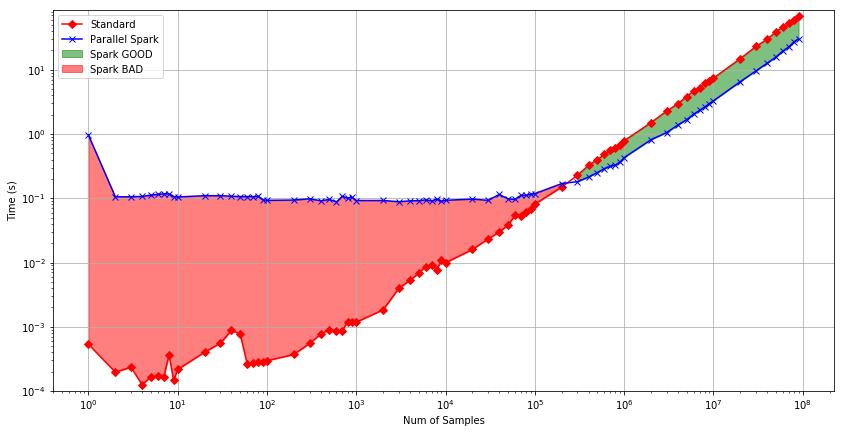

In [9]:
fig = plt.figure(figsize=(14,7))

ax=plt.gca()
ax.plot(samples,data[:,2],label='Standard',color='red',marker='D',clip_on=False)
ax.plot(samples,times2,label='Parallel Spark',color='blue',marker='x',clip_on=False)
ax.fill_between(samples,data[:,2],times2,where=data[:,2]>=times2,color='green',alpha=0.5,label='Spark GOOD')
ax.fill_between(samples,data[:,2],times2,where=data[:,2]<=times2,color='red',alpha=0.5,label='Spark BAD')
ax.set_xlabel('Num of Samples')
ax.set_ylabel('Time (s)')
ax.grid()
ax.set_ylim(min(min(data[:,2]),min(times2))*0.8,max(max(data[:,2]),max(times2))*1.2)
ax.legend()
ax.set_xscale('log')
ax.set_yscale('log')

plt.show()

You should have noticed the execution time is significantly shorter with Spark's `parallelize` method than without using Spark. However, if you find the execution time is actually longer, it could be because your code is not efficient or Spark doesn't have access to multiple CPU cores. If it's the latter case, don't worry. You can still experience the power of parallel programming in Challenge 4 when we run Spark in the cluster mode.

You may have also noticed the first time to execute your function takes significantly longer time than executing it in the second and third time (you need to execute the commands consequtively in a row). This is because at the first time you execute the function, Spark has to acquire the memory and CPUs it needs from the system. After the execution is finished Spark does not release the memory immediately. So when you execute the script consequtively, Spark does not need to acquire the hardware resources again.

Spark is written in Java (you are interacting with its Java core via a Python wrapper). Java applications typically maintain a minimum memory even if it is idling. When memory-demanding processes are being executed, Java will *burst* its memory consumption by acquiring more from the system.

# Data Wrangling with PySpark Dataframes

Next, you will be practicing data wrangling with the Pandas-like dataframes that PySpark provides you. You should have already used the equivalent of these functions with Pandas in the previous labs. We just want to show you the Spark way of doing the similar things. Note that the syntax in Pyspark is different from that in Pandas. Use Google to find the examples you need.

#### Import `SparkSession` from `pyspark.sql`. Create a new instance of SparkSession.

In [68]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('patients').getOrCreate()

#### Read a CSV dataset from a previous lab using `spark.read.csv()` and assign the returned dataframe into a variable called `patients`.

The dataset path is `../lab-sklearn-and-unsupervised-learning/patient-admission-dataset-for-learning-data-mining.csv`. 

*Hint: Use `spark.read.csv()` to read from the dataset.*

In [69]:
# Use `spark.read.csv
patients = spark.read.csv('../lab-sklearn-and-unsupervised-learning/patient-admission-dataset-for-learning-data-mining.csv', 
                          header=True)

#### Print a summary of `patients` using `printSchema()`.

*Hint: Use `printSchema`.*

In [70]:
# Your code here
patients.printSchema()

root
 |-- id: string (nullable = true)
 |-- patient_name: string (nullable = true)
 |-- patient_email: string (nullable = true)
 |-- doctor_phone: string (nullable = true)
 |-- patient_gender: string (nullable = true)
 |-- patient_dob: string (nullable = true)
 |-- patient_diabetic: string (nullable = true)
 |-- patient_allergic: string (nullable = true)
 |-- patient_weight_kg: string (nullable = true)
 |-- patient_height_sm: string (nullable = true)
 |-- patient_nhs_number: string (nullable = true)
 |-- doctor_name: string (nullable = true)
 |-- appointment_date: string (nullable = true)
 |-- patient_show: string (nullable = true)
 |-- is_regular_visit: string (nullable = true)
 |-- prescribed_medicines: string (nullable = true)
 |-- diagnosis: string (nullable = true)



#### Count the missing values in the `patients["diagnosis"]`. Your output should be `488`.

In [71]:
# Your code here

print('Number of missing values in Diagnosis: ',patients.filter(patients['diagnosis'].isNull()).count())

Number of missing values in Diagnosis:  488


#### Print the `diagnosis` column in `patients`.

*Hint: First select the column (`.select()`) then use the `show()` method*.

In [72]:
# Your code here
patients.select('diagnosis').show()

+---------+
|diagnosis|
+---------+
|     I669|
|     null|
|     null|
|     null|
|     null|
|     null|
|  S72309N|
|     null|
|   T508X6|
|     null|
|     S420|
|    T8743|
|  M80072A|
|     null|
|     null|
|     null|
|  T22342A|
|     null|
|     null|
|     null|
+---------+
only showing top 20 rows



#### Fill the missing values in column `diagnosis` with a string `no diagnosis`.

*Hint: Use `.fillna()`.*

In [73]:
# Your code here

patients = patients.fillna({'diagnosis':'no diagnosis'})

In [74]:
print('Missing values: ',patients.filter(patients['diagnosis'].isNull()).count())

Missing values:  0


#### Print the `diagnosis` column again to confirm null values are replaced.

In [75]:
# Your code here
patients.select('diagnosis').show()

+------------+
|   diagnosis|
+------------+
|        I669|
|no diagnosis|
|no diagnosis|
|no diagnosis|
|no diagnosis|
|no diagnosis|
|     S72309N|
|no diagnosis|
|      T508X6|
|no diagnosis|
|        S420|
|       T8743|
|     M80072A|
|no diagnosis|
|no diagnosis|
|no diagnosis|
|     T22342A|
|no diagnosis|
|no diagnosis|
|no diagnosis|
+------------+
only showing top 20 rows



#### Count the missing values in column `doctor_name`. You should see output `58`.

In [76]:
# Your code here
print('Missing values: ',patients.filter(patients['doctor_name'].isNull()).count())

Missing values:  58


#### Drop the rows in `patients` where column `doctor_name` is missing data. Remember to assign the converted dataset back to `patients`.

*Hint: Use `.dropna()`.*

In [77]:
# Your code here
patients = patients.na.drop(subset=["doctor_name"])

#### Now count the missing values in `doctor_name` again. You should see output `0`.

In [78]:
# Your code here
patients.filter( patients["doctor_name"].isNull() ).count()

0

#### Convert the boolean columns `patient_show`, `is_regular_visist`, `patient_diabetic`, and `patient_allergic` to int.

*Hint: [Here](https://stackoverflow.com/questions/33354571/casting-a-new-derived-column-in-a-dataframe-from-boolean-to-integer) is an example.*

In [79]:
# Needed functionality
from pyspark.sql import functions as F

In [80]:
# Your code here

for item in ['patient_show','is_regular_visit','patient_diabetic','patient_allergic']:
    patients = patients.withColumn(item, 
                                   F.when(F.col(item)=="true",1).otherwise(0))


In [81]:
patients.select('patient_show','is_regular_visit','patient_diabetic','patient_allergic').show()

+------------+----------------+----------------+----------------+
|patient_show|is_regular_visit|patient_diabetic|patient_allergic|
+------------+----------------+----------------+----------------+
|           1|               1|               0|               1|
|           1|               1|               0|               1|
|           0|               0|               1|               1|
|           0|               1|               1|               1|
|           0|               0|               0|               1|
|           0|               1|               0|               1|
|           0|               0|               1|               1|
|           0|               0|               0|               0|
|           0|               0|               1|               0|
|           1|               0|               0|               0|
|           0|               1|               1|               1|
|           0|               1|               0|               0|
|         

#### Add a new column called `diagnosis_int`. The value in this column should be `0` if the corresponding row of the `diagnosis` column is `no diagnosis`. Otherwise the value should be `1`.

*Hint: The way to add a derived coloumn is similar to converting a column values as you've done in the previous question.*

In [83]:
# Your code here

patients = patients.withColumn('diagnosis_int', 
                    F.when(F.col('diagnosis')=='no diagnosis',0).otherwise(1))

patients.select('diagnosis_int').show()

+-------------+
|diagnosis_int|
+-------------+
|            1|
|            0|
|            0|
|            0|
|            0|
|            0|
|            1|
|            0|
|            1|
|            0|
|            1|
|            1|
|            1|
|            0|
|            0|
|            0|
|            1|
|            0|
|            0|
|            0|
+-------------+
only showing top 20 rows



#### Add a new column called `gender_int`. The value in this column should be `0` if the corresponding row of the `patient_gender` column is `Male`. Otherwise the value should be `1`.

In [86]:
# Your code here
patients = patients.withColumn('gender_int', 
                    F.when(F.col('patient_gender')=='Male',0).otherwise(1))

patients.select('gender_int').show()

+----------+
|gender_int|
+----------+
|         1|
|         1|
|         1|
|         0|
|         1|
|         1|
|         0|
|         1|
|         0|
|         0|
|         0|
|         1|
|         0|
|         0|
|         1|
|         0|
|         1|
|         1|
|         0|
|         1|
+----------+
only showing top 20 rows



Due to the time limitation for this lab, we won't go through all steps of data wrangling like we did in the Unsupervised Learning with Scikit-Learn Lab. We'll simply keep the numerical columns we have so far and drop the rest so that we'll have time to practice MLlib.

#### Drop the following columns from `patients`: 

```
['id', 'patient_name', 'patient_email', 'patient_nhs_number', 'doctor_phone', 'patient_dob', 'doctor_name', 'appointment_date', 'prescribed_medicines', 'diagnosis', 'patient_gender']
```

In [92]:
# Your code here
drop_list = ['id', 'patient_name', 
             'patient_email', 
             'patient_nhs_number', 
             'doctor_phone', 'patient_dob', 
             'doctor_name', 'appointment_date', 
             'prescribed_medicines', 
             'diagnosis', 
             'patient_gender']

patients = patients.select([column for column in patients.columns if column not in drop_list])

#### Call `printSchema()` again for `patients`. You should see all fields remaining are interger types.

In [93]:
# Your code here

patients.printSchema()

root
 |-- patient_diabetic: integer (nullable = false)
 |-- patient_allergic: integer (nullable = false)
 |-- patient_weight_kg: string (nullable = true)
 |-- patient_height_sm: string (nullable = true)
 |-- patient_show: integer (nullable = false)
 |-- is_regular_visit: integer (nullable = false)
 |-- diagnosis_int: integer (nullable = false)
 |-- gender_int: integer (nullable = false)



#### You now get the feeling that PySpark have similar features as Pandas to perform data wrangling. However data wrangling with PySpark is not as convenient as in Pandas because PySpark is specialized for data engineering rather than data processing. The real value of Spark is to compute really big datasets with complex and time-consuming algorithms. Many data scientists/engieers use Pandas for data wrangling then import the data to Spark for computation.

# KMeans Analysis Example

Finally we will show you an example of clustering the cleaned data with KMeans. Because you have done the same thing in the Supervised Learning with Scikit-Learn lab, we won't ask you to figure it out with PySpark's MLlib. We are providing the code for you to reference.

In order to perform KMeans analysis in PySpark, **we need to first use the `VectorAssembler` to convert the existing data into high-dimensional vectors**. We will assign the generated vectors into a new column called `features`.

In [96]:
for col in patients.columns:
    patients = patients.withColumn(col, patients[col].cast("double"))

In [97]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(
    inputCols=["patient_diabetic", "patient_allergic", "patient_weight_kg", "patient_height_sm", "patient_show", "is_regular_visit", "diagnosis_int", "gender_int"],
    outputCol="features")

output = assembler.transform(patients)
output.select("features").show(truncate=False)

+-------------------------------------+
|features                             |
+-------------------------------------+
|[0.0,1.0,59.0,176.0,1.0,1.0,1.0,1.0] |
|[0.0,1.0,77.0,186.0,1.0,1.0,0.0,1.0] |
|[1.0,1.0,90.0,177.0,0.0,0.0,0.0,1.0] |
|[1.0,1.0,70.0,150.0,0.0,1.0,0.0,0.0] |
|(8,[1,2,3,7],[1.0,82.0,140.0,1.0])   |
|[0.0,1.0,105.0,179.0,0.0,1.0,0.0,1.0]|
|[1.0,1.0,87.0,180.0,0.0,0.0,1.0,0.0] |
|(8,[2,3,7],[73.0,152.0,1.0])         |
|(8,[0,2,3,6],[1.0,83.0,156.0,1.0])   |
|(8,[2,3,4],[89.0,160.0,1.0])         |
|[1.0,1.0,108.0,165.0,0.0,1.0,1.0,0.0]|
|[0.0,0.0,53.0,147.0,0.0,1.0,1.0,1.0] |
|[1.0,0.0,51.0,170.0,1.0,1.0,1.0,0.0] |
|[1.0,1.0,106.0,142.0,1.0,0.0,0.0,0.0]|
|(8,[1,2,3,7],[1.0,58.0,169.0,1.0])   |
|(8,[0,2,3],[1.0,64.0,150.0])         |
|[1.0,0.0,56.0,168.0,1.0,1.0,1.0,1.0] |
|[0.0,1.0,69.0,182.0,1.0,0.0,0.0,1.0] |
|(8,[1,2,3,5],[1.0,69.0,178.0,1.0])   |
|[0.0,1.0,77.0,155.0,1.0,1.0,0.0,1.0] |
+-------------------------------------+
only showing top 20 rows



Then we import the `KMeans` class from Pyspark's MLlib and fit the new dataset with the `features` column to KMeans. We call `KMeans().setK(4)` to indicate we would like to receive 4 data clusters. Finally we print the center of each cluster.

In [98]:
from pyspark.ml.clustering import KMeans

kmeans = KMeans().setK(4).setSeed(1)

model = kmeans.fit(output)

wssse = model.computeCost(output)
print("Within Set Sum of Squared Errors = " + str(wssse))

centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Within Set Sum of Squared Errors = 119574.87827302358
Cluster Centers: 
[  0.51260504   0.52941176  62.76890756 176.96638655   0.47058824
   0.5          0.44957983   0.55042017]
[  0.55504587   0.51834862  97.75229358 153.49541284   0.49082569
   0.50458716   0.59174312   0.48165138]
[  0.50643777   0.49785408  65.5751073  152.26180258   0.50643777
   0.55364807   0.50643777   0.44635193]
[  0.48616601   0.49407115  93.88142292 178.70355731   0.50988142
   0.52964427   0.51778656   0.53754941]


___